In [97]:
# Import libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [50]:
# Extract data
data = pd.read_csv(f'../../ETL/Load/stockData.csv', header=(0), sep=';')

In [51]:
# Separate train and test data
# Train: first 8 years
# Test: last 2 years

data['DATE'] = pd.to_datetime(data['DATE'])
data_train = data[data['DATE'].dt.year <= 2021]
data_test = data[data['DATE'].dt.year > 2021]

In [52]:
# Function to remove outliers using std
def remove_outliers_std(data_train, data_test, column, factor = 3):
    data_std = data_train[column].std()
    data_mean = data_train[column].mean()
    lower_bound = data_mean - factor * data_std
    upper_bound = data_mean + factor * data_std
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

# Function to remove outliers using IQR
def remove_outliers_iqr(data_train, data_test, column, factor = 1.5):
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    data_train = data_train[(data_train[column] >= lower_bound) & (data_train[column] <= upper_bound)]
    data_test = data_test[(data_test[column] >= lower_bound) & (data_test[column] <= upper_bound)]
    return data_train, data_test

In [53]:
# List of features and the class column
features = data.columns.tolist()[2:-1]
binary_class = data.columns.tolist()[-1]

# Replace inf values by very large number
data.replace(np.inf, 1e20, inplace=True)

# Clean outliers from data
method = 'iqr' # std or iqr
factor = 9

if method == 'std':
    for feature in features:
        data_train, data_test = remove_outliers_std(data_train, data_test, feature, factor)
elif method == 'iqr':
    for feature in features:
        data_train, data_test = remove_outliers_iqr(data_train, data_test, feature, factor)

In [54]:
# Change data to numpy
data_train = data_train.to_numpy()
data_test = data_test.to_numpy()

# Get number of rows and columns
ncol = data.shape[1]

# Get arrays for features and class
y_train = data_train[:,-1]
X_train = data_train[:,2:ncol-2]
y_test = data_test[:,-1]
X_test = data_test[:,2:ncol-2]

In [55]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [56]:
# Convert y to integer
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [57]:
# Upsample 1 Class
# Convert X_train and y_train to DataFrame and Series, respectively
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Split the dataset by class
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Resample minority class to match the majority class size
X_train_minority_upsampled = resample(X_train_minority, 
                                      replace=True,     
                                      n_samples=len(X_train_majority),  
                                      random_state=42)

y_train_minority_upsampled = resample(y_train_minority, 
                                      replace=True,     
                                      n_samples=len(y_train_majority),  
                                      random_state=42)

# Combine majority class and upsampled minority class
X_train_balanced = pd.concat([X_train_majority, X_train_minority_upsampled])
y_train_balanced = pd.concat([y_train_majority, y_train_minority_upsampled])

# Shuffle the data
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [58]:
# Train Logistic Regression Model
model = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
model.fit(X_train_balanced, y_train_balanced)

# Scale test data
X_test = scaler.transform(X_test)

# Predict y with test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)



Accuracy: 0.626078132927448
Precision: 0.05922865013774105
Recall (Sensitivity): 0.44329896907216493
F1-Score: 0.10449574726609964


In [59]:
# Information on the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Classes:", model.classes_)
print("Iterations to Converge:", model.n_iter_)

Coefficients: [[ 0.19774665  0.26637218  0.06998699 -0.20137946  0.23954361 -0.1994723
  -0.24193129  0.14913883 -0.02565576 -0.08556958 -0.06871984]]
Intercept: [-0.08834697]
Classes: [0 1]
Iterations to Converge: [10]


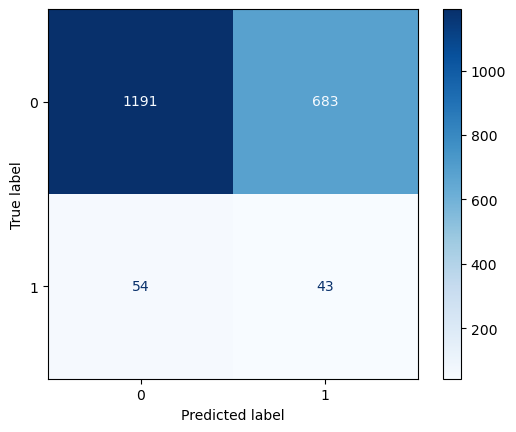

In [100]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cm_display.plot(cmap=plt.cm.Blues)
# Save the figure for cleaned data
output_dir = 'Graphs'
plt.savefig(os.path.join(output_dir, f'confusionMatrix_LR.png'))
plt.show()

In [68]:
sum(data_test[:,14])/len(data_test[:,14])

0.049213597158802636

In [85]:
TOTAL = len(data_test[:,14])

In [86]:
P = sum(data_test[:,14])

In [87]:
N = len(data_test[:,14])-sum(data_test[:,14])
N

1874

In [88]:
VP = sum(data_test[:,14])/2
FN = P - VP

In [89]:
VN = N/2
FP = N - VN

In [94]:
(VP+VN)/(VP+VN+FP+FN)

0.5

In [95]:
2*0.0492*0.5/(0.0492+0.5)

0.0895848506919155